[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ClimateMatchAcademy/course-content/blob/main/tutorials/W2D1_FutureClimate-IPCCIPhysicalBasis/W2D1_Tutorial_1.ipynb) &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/{ORG}/course-content/main/tutorials/W2D1_FutureClimate-IPCCIPhysicalBasis/W2D1_Tutorial_1.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# **Tutorial 1: Creating Maps of CMIP6 Earth System Model (ESM) Projections**

**Week 2, Day 1, Future Climate: The Physical Basis**

**Content creators:** Brodie Pearson, Julius Busecke, Tom Nicholas

**Content reviewers:** Younkap Nina Duplex, Zahra Khodakaramimaghsoud, Sloane Garelick, Peter Ohue, Jenna Pearson, Agustina Pesce, Derick Temfack, Peizhen Yang, Cheng Zhang, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Ohad Zivan, Chi Zhang

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS and Google deepmind

# **Tutorial Objectives**
Earth System Models (ESMs) provide physically-based projections of how Earth's climate could change in the coming years, decades, and centuries at both global and local scales. In the following tutorial you will:

- Revisit how to load ESM data from the CMIP6 experiments, and 
- Create maps showing projected future changes in sea surface temperature (SST).

# **Setup**


In [3]:
# !pip install condacolab &> /dev/null
# import condacolab
# condacolab.install()

# # Install all packages in one call (+ use mamba instead of conda), this must in one line or code will fail
# !mamba install xarray-datatree intake-esm gcsfs xmip aiohttp cartopy nc-time-axis cf_xarray xarrayutils "esmf<=8.3.1" xesmf &> /dev/null
# # For xesmf install we need to pin "esmf<=8.3.1". More context here: https://github.com/pangeo-data/xESMF/issues/246

In [4]:
# imports
import time
tic = time.time()

import intake
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe

from xmip.preprocessing import combined_preprocessing
from xarrayutils.plotting import shaded_line_plot

from datatree import DataTree
from xmip.postprocessing import _parse_metric

import cartopy.crs as ccrs

In [5]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

%matplotlib inline

In [6]:
# @title Video 1: Recap of Earth System Models
#Tech team will add code to format and display the video

## **Section 1.1: Loading CMIP6 SST Data with `xarray`**

As a reminder, these ESMs simulate several systems (ocean, atmosphere, cryosphere, land) that are coupled to each other, and each system has its own variables, physics, and discretizations (grid & timestep).

<img src="https://upload.wikimedia.org/wikipedia/commons/7/73/AtmosphericModelSchematic.png" alt= “EarthSystemModel” width="420" height="400">|
-

Atmospheric Model Schematic (Credit: [Wikipedia](https://upload.wikimedia.org/wikipedia/commons/7/73/AtmosphericModelSchematic.png))

Let's repeat the CMIP6 loading method that we learned in Tutorial 6 on last week's Climate Modelling day (Day 5).

 **Although we will only work with monthly SST (ocean) data today, the methods introduced can easily be applied/extended to load and analyze other CMIP6 variables, including from other components of the Earth system.**

As a reminder, the *facets* that have to be specified for CMIP6, along with the facet choice(s) we make in this tutorial, are:
1. **variable_id**: *tos* = sea surface temperature
2. **source_id**: The CMIP6 model(s) that we want data from 
3. **table_id**: *Omon* (ocean monthly output)
4. **grid_id**: *gn* = data on the model's *native* grid
5. **experiment_id**: *ssp585* (we'll discuss experiments later today)
6. **member_id**: *r1i1p1f1* for now

Now, let's repeat our CMIP6 loading method from the previous tutorial.

*Note: today we will start by using only use one model, **TaiESM1**, which stands for **Taiwan Earth System Model version 1**, and a single experiment, **ssp585** which is a high-emissions future scenario. In later tutorials you will work with 5 distinct CMIP6 models (**source_id**), and two additional experiments (**experiment_id**). **TaiESM1** was developed by modifying the Community Earth System Model (**CESM**) version 1.2.2 to include different parameterizations (i.e., physics). As a result, the **TaiESM1** model output is distinct from the **CESM** output you used in previous tutorials/days.*


In [7]:
# open an intake catalog containing the Pangeo CMIP cloud data
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

# from the full `col` object, create a subset using facet search
cat = col.search(
    source_id='TaiESM1',
    variable_id='tos',
    member_id='r1i1p1f1',
    table_id='Omon',
    grid_label='gn',
    experiment_id = 'ssp585',
    require_all_on = ['source_id'] #make sure that we only get models which have all of the above experiments
)

# convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
kwargs = dict(
    preprocess=combined_preprocessing, #apply xMIP fixes to each dataset
    xarray_open_kwargs=dict(use_cftime=True), #ensure all datasets use the same time index
    storage_options={'token':'anon'} #anonymous/public authentication to google cloud storage
)

cat.esmcat.aggregation_control.groupby_attrs = ['source_id', 'experiment_id']
dt = cat.to_datatree(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


We now have a "datatree" containing the data we searched for. A datatree is a high-level container of xarray data, useful for organizing many related datasets together. You can think of a single `DataTree` object as being like a (nested) dictionary of `xarray.Dataset` objects. Each dataset in the tree is known as a "node" or "group", and we can also have empty nodes. *This `DataTree` object may seem complicated when we load only one dataset, but it will prove to be very useful in later tutorials where you will work with multiple models, experiments, and ensemble members* 

You can explore the nodes of the tree and its contents interactively in a similar way to how you can explore the contents of an `xarray.Dataset`:

In [8]:
dt

DataTree('None', parent=None)
└── DataTree('TaiESM1')
    └── DataTree('ssp585')
            Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1032, y: 384,
                                 x: 320, vertex: 4, bnds: 2)
            Coordinates:
                lat             (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
                lon             (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
              * time            (time) object 2015-01-17 00:29:59.999993 ... 2100-12-16 1...
                lat_verticies   (y, x, vertex) float64 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
                lon_verticies   (y, x, vertex) float64 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
                time_bounds     (time, bnds) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
              * y               (y) int64 0 1 2 3 4 5 6 7 ... 377 378 379 380 381 382 383
              * x               (x) int64 0 1 2 3 4 5 6 7 ... 313 314 315 316 317 318 319
                lon_bounds      (bnds, y, x) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
                lat_bounds      (bnds, y, x) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
              * member_id       (member_id) object 'r1i1p1f1'
              * dcpp_init_year  (dcpp_init_year) float64 nan
            Dimensions without coordinates: vertex, bnds
            Data variables:
                tos             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 87, 384, 320), meta=np.ndarray>
            Attributes: (12/62)
                Conventions:                      CF-1.7 CMIP-6.2
                activity_id:                      ScenarioMIP
                branch_method:                    Hybrid-restart from year 2015-01-01 of ...
                branch_time_in_child:             0.0
                branch_time_in_parent:            60225.0
                cmor_version:                     3.5.0
                ...                               ...
                intake_esm_attrs:variable_id:     tos
                intake_esm_attrs:grid_label:      gn
                intake_esm_attrs:zstore:          gs://cmip6/CMIP6/ScenarioMIP/AS-RCEC/Ta...
                intake_esm_attrs:version:         20210416
                intake_esm_attrs:_data_format_:   zarr
                intake_esm_dataset_key:           TaiESM1/ssp585

Now that we have the model datasets organized within thie datatree (`dt`) we can plot the datasets. Let's start by plotting a map of SST from the `TaiESM1` CMIP6 model in July 2023. 

*Note that CMIP6 experiments were run several years ago, so the cut-off between **past** (observed forcing) and **future** (scenario-based/projected forcing) was at the start of 2015. This means that July 2023 is about 8 years into the CMIP6 **future** and so it is unlikely to look exactly like Earth's current SST state.*

Text(0.5, 1.0, 'July 2023')

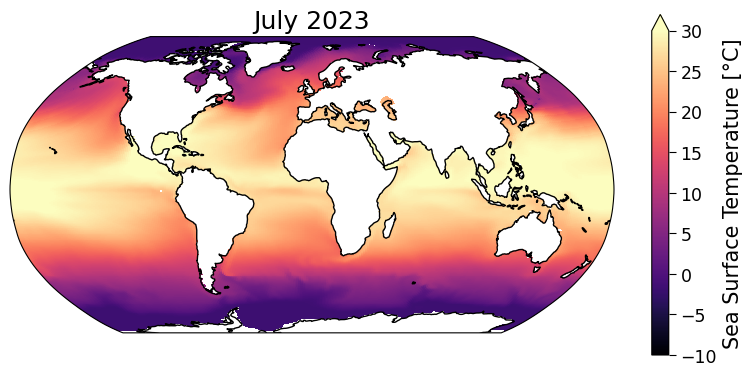

In [9]:
# select just a single model (TaiESM1) and experiment (ssp585) to plot
sst_ssp585 = dt['TaiESM1']['ssp585'].ds.tos

fig, (ax_present) = plt.subplots(
    ncols=1, nrows=1,
    figsize=[8,4],
    subplot_kw={'projection':ccrs.Robinson()}
)

# select the model data for July 2023
sst_present = sst_ssp585.sel(time='2023-07').squeeze()

# plot the model data
sst_present.plot(ax=ax_present, x='lon', y='lat', transform=ccrs.PlateCarree(), vmin=-10, vmax=30, cmap='magma', robust=True)
ax_present.coastlines()
ax_present.set_title('July 2023')

### **Coding Exercise 1.1**

Now that we can plot maps of CMIP6 data, let's look at some projected future changes using this data!

In this coding exercise your goals are to: 
1. Create a map of the projected sea surface temperature in July 2100 under the SSP5-8.5 high-emissions scenario (we'll discuss scenarios in the next mini-lecture) using data from the *TaiESM1* CMIP6 model.
2. Create a map showing how this sea surface temperature projection is different from the current (July 2023) sea surface temperature in this model
3. Plot a similar map for this model that shows how *January* 2100 is different from *January* 2023

To get you started, we have provided code to load the required data set into a variable called *sst_ssp585*, and we have plotted the current (July 2023) sea surface temperature from this data set.

*Note: differences between two snapshots of SST are not the same as the **anomalies** that you encountered earlier in the course, which were the difference relative to the average during a reference period.*

In [ ]:
# select just a single model and experiment
sst_ssp585 = dt['TaiESM1']['ssp585'].ds.tos

fig, ([ax_present, ax_future], [ax_diff_july, ax_diff_jan]) = plt.subplots(
    ncols=2, nrows=2,
    figsize=[12,6],
    subplot_kw={'projection':ccrs.Robinson()}
)

# plot a timestep for 2023
sst_present = sst_ssp585.sel(time='2023-07').squeeze()
sst_present.plot(ax=ax_present, x='lon', y='lat', transform=ccrs.PlateCarree(), vmin=-10, vmax=30, cmap='magma', robust=True)
ax_present.coastlines()
ax_present.set_title('July 2023')

# repeat for 2100
# complete the following line to extract data for July 2100
sst_future = ...
_ = ...
ax_future.coastlines()
ax_future.set_title('July 2100')

# now find the difference between July 2100 and July 2023
# complete the following line to extract the July difference
sst_difference_july = ...
_ = ...
ax_diff_july.coastlines()
ax_diff_july.set_title('2100 vs. 2023 Difference (July)')

# finally, find the difference between January of the two years used above
# complete the following line to extract the January difference
sst_difference_jan = ...
_ = ...
ax_diff_jan.coastlines()
ax_diff_jan.set_title('2100 vs. 2023 Difference (January)')

Text(0.5, 1.0, '2100 vs. 2023 Difference (January)')

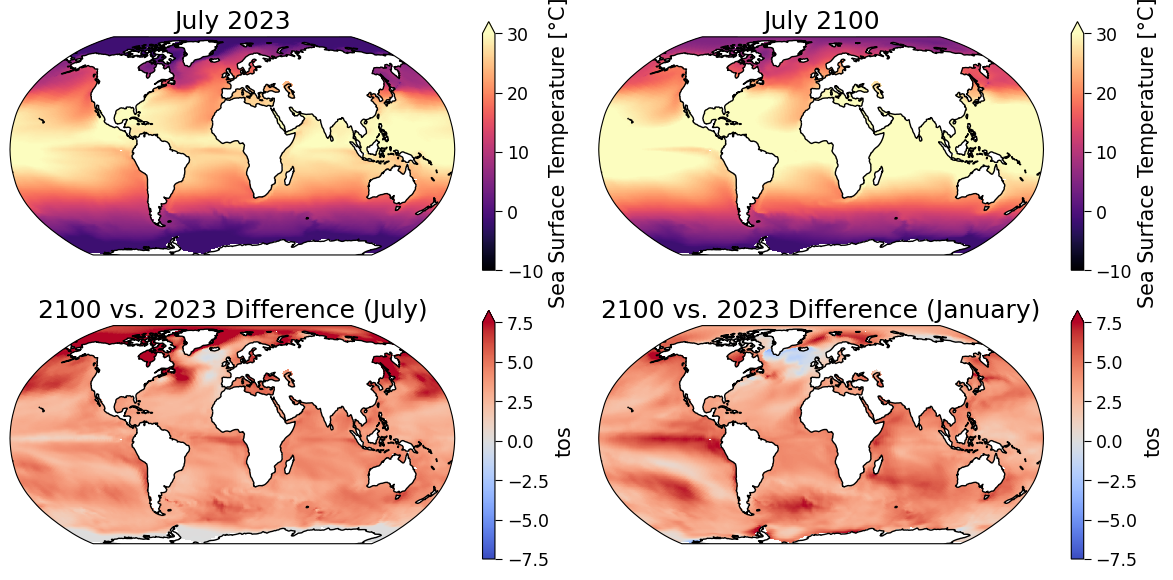

In [10]:
# to_remove solution
# select just a single model and experiment
sst_ssp585 = dt['TaiESM1']['ssp585'].ds.tos

fig, ([ax_present, ax_future], [ax_diff_july, ax_diff_jan]) = plt.subplots(
    ncols=2, nrows=2,
    figsize=[12,6],
    subplot_kw={'projection':ccrs.Robinson()}
)

# plot a timestep for 2023
sst_present = sst_ssp585.sel(time='2023-07').squeeze()
sst_present.plot(ax=ax_present, x='lon', y='lat', transform=ccrs.PlateCarree(), vmin=-10, vmax=30, cmap='magma', robust=True)
ax_present.coastlines()
ax_present.set_title('July 2023')

# repeat for 2100
# complete the following line to extract data for July 2100
sst_future = sst_ssp585.sel(time='2100-07').squeeze()
_ = sst_future.plot(ax=ax_future, x='lon', y='lat', transform=ccrs.PlateCarree(), vmin=-10, vmax=30, cmap='magma', robust=True)
ax_future.coastlines()
ax_future.set_title('July 2100')

# now find the difference between July 2100 and July 2023
# complete the following line to extract the July difference
sst_difference_july = sst_future - sst_present
_ = sst_difference_july.plot(ax=ax_diff_july, x='lon', y='lat', transform=ccrs.PlateCarree(), vmin=-7.5, vmax=7.5, cmap='coolwarm')
ax_diff_july.coastlines()
ax_diff_july.set_title('2100 vs. 2023 Difference (July)')

# finally, find the difference between January of the two years used above
# complete the following line to extract the January difference
sst_difference_jan = sst_ssp585.sel(time='2100-01').squeeze() - sst_ssp585.sel(time='2023-01').squeeze()
_ = sst_difference_jan.plot(ax=ax_diff_jan, x='lon', y='lat', transform=ccrs.PlateCarree(), vmin=-7.5, vmax=7.5, cmap='coolwarm')
ax_diff_jan.coastlines()
ax_diff_jan.set_title('2100 vs. 2023 Difference (January)')

## **Questions 1.1: Climate Connection**

1.   *Comparing only the top two panels*, how is the July SST projected to change in this particular model simulation? Do these changes agree with the map of July change that you plotted in the bottom left, and are these changes easier to see in this bottom map?
2.   In what ways are the July and January maps similar or dissimilar, and can you think of any physical explanations for these (dis)similarities?
3. Why do you think the color bar axes vary? (i.e., the top panels say "*Sea Surface Temperature [$^oC$]*" while the bottom panels say "*tos*")

Many of the changes seen in the maps are a result of a changing climate under this high-emissions scenarios. However, keep in mind that these are differences between two months that are almost 80 years apart, so some of the changes are due to weather/synoptic differences between these particular months.


In [ ]:
# to_remove explanation

"""
1. Based on the top maps, it looks like the Equator and low latitudes warm significantly, and the higher latitudes also warm. The northern hemisphere warms more than the southern hemisphere. These changes agree qualitatively with the "change map" (bottom left), although the change map makes it clear that the Arctic surface waters are warming faster than the rest of the planet and that the warming is not spatially uniform anywhere (in fact parts of the North Atlantic cool slightly!). The warming in the low latitudes and Southern hemisphere is still significant, and shows interesting spatial patterns.
2. There are various things you might notice. For example, the January maps show more warming in the Southern hemisphere than the July maps, consistent with the Southern hemisphere summer creating a warmer baseline and more potential for extreme heat. We also see warming in the Equatorial Pacific region for January, which was not present for July, which could be due different ENSO phases across the two months and the two years. A final example is that the North Atlantic shows even stronger cooling in January than in July, this is a common signal in many climate models. This cooling can result from melting ice sheets and glaciers creating colder, fresher surface water, which increases stratification. This can reduce the amount of deep convection in the North Atlantic region (by trapping fresh cold water at the surface),weakening the thermohaline circulation.
3. The metadata of the CMIP6 dataset we are using in the first two plots contains a long-name for the variable and its units, which are automatically used for the axis labels. When we perform a mathematical operation (subtraction) on the dataset to create a new DataArray, the long-name metadata is not transferred to the new array to avoid confusion in case the operation creates a new variable (that could also have different units). This leads to the plot using the variable name (tos) for the x-axis instead of the long name.
""";

## **Section 1.2: Horizontal Regridding**

Many CMIP6 models use distinct spatial grids, we call this the model's *native grid*. 

You are likely familiar with the *regular latitude-longitude* grid where we separate the planet into boxes that have a fixed latitude and longitude span like this image we saw in the tutorial:

<img src="https://upload.wikimedia.org/wikipedia/commons/4/4c/Azimutalprojektion-schief_kl-cropped.png" alt= "Lat_Lon_Grid" width="250" height="250">|
-

Let's look at the grid used for the ocean component of the *TaiESM1* CMIP6 model:


Text(0.5, 1.0, 'Grid cell locations in TaiESM1')

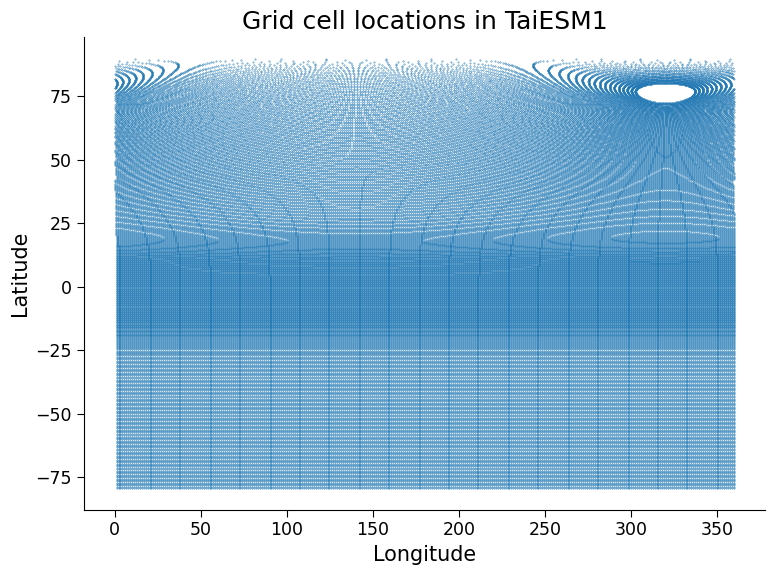

In [11]:
# create a scatter plot with a symbol at the center of each ocean grid cell in TaiESM1
fig,ax=plt.subplots()
ax.scatter(x=sst_ssp585.lon, y=sst_ssp585.lat, s=0.1)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_title('Grid cell locations in TaiESM1')

## **Questions 1.2**

1. How would this plot look for a *regular latitude-longitude* grid like the globe image shown above and in the slides? In what ways is the TaiESM1 grid different from this regular grid?
2. Can you think of a reason the Northern and Southern hemisphere ocean grids differ?*

**Hint: from an oceanographic context, how are the North and South poles different from each other?*

In [ ]:
# to_remove explanation

"""
1. For a regular latitude-longitude grid the plot should consist of straight lines from top to bottom, and straight lines from left to right, that are evenly spaced in each of those directions. The grid of TaiESM1 looks like a regular latitude-longitude grid in the Southern hemisphere, but is quite different in the Northern hemisphere, with the grid cells getting small (converging) at a "grid North pole" which is actually placed at ~75 degrees North and 40 degrees West. a large part of this "grid North pole" doesn't contain any grid points (the white hole).
2. On a regular latitude-longitude grid, the grid cells rapidly get very small as you approach the pole which causes numerical issues for ocean model. For example, the time step has to be reduced to physically capture the movement between the smallest cells, leading to many more computations required to evolve the model. This is not a problem for ocean models at the South Pole because the pole is on land! In the Northern hemisphere, it is common to move the "grid North pole" of ocean models to occur in a land region (e.g., Asian and/or North American continents), and sometimes there are poles in both these land masses!
""";

If you want to compare spatial maps from different models/observations, e.g. plot a map averaged over several models or the bias of this map relative to observations, you must first ensure the data from all the models (and observations) is on the same spatial grid. This is where regridding becomes essential!

> Regridding is applied lazily, but it is still taking time to compute *when* it is applied. So if you want to compare for example the mean over time of several models it is often much quicker to compute the mean in time over the native grid and then regrid the result of that, instead of regridding each timestep and then calculating the mean!

In [12]:
# define a 'target' grid. This is simply a regular lon/lat grid that we will interpolate our data on
ds_target = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-90, 90, 1.0), {"units": "degrees_north"}),
        "lon": (["lon"], np.arange(0, 360, 1.0), {"units": "degrees_east"}),
    }
) # you can try to modify the parameters above to e.g. just regrid onto a region or make the resolution coarser etc
ds_target

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 86.0 87.0 88.0 89.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    *empty*

In [13]:
# define the regridder object (from our source dataarray to the target)
regridder = xe.Regridder(sst_ssp585, ds_target, 'bilinear', periodic=True) # this takes some time to calculate a weight matrix for the regridding
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_384x320_180x360_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (384, 320) 
Output grid shape:          (180, 360) 
Periodic in longitude?      True

In [14]:
# now we can apply the regridder to our data
sst_ssp585_regridded = regridder(sst_ssp585) # this is a lazy operation!
  # so it does not slow us down significantly to apply it to the full data!
  # we can work with this array just like before and the regridding will only be
  # applied to the parts that we later load into memory or plot.
sst_ssp585_regridded

<xarray.DataArray (member_id: 1, dcpp_init_year: 1, time: 1032, lat: 180,
                   lon: 360)>
dask.array<_regrid, shape=(1, 1, 1032, 180, 360), dtype=float32, chunksize=(1, 1, 87, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) object 2015-01-17 00:29:59.999993 ... 2100-12-16 1...
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
  * lat             (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0
  * lon             (lon) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
Attributes:
    regrid_method:  bilinear

In [15]:
# compare the shape to the original array
sst_ssp585

<xarray.DataArray 'tos' (member_id: 1, dcpp_init_year: 1, time: 1032, y: 384,
                         x: 320)>
dask.array<broadcast_to, shape=(1, 1, 1032, 384, 320), dtype=float32, chunksize=(1, 1, 87, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    lat             (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon             (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time            (time) object 2015-01-17 00:29:59.999993 ... 2100-12-16 1...
  * y               (y) int64 0 1 2 3 4 5 6 7 ... 377 378 379 380 381 382 383
  * x               (x) int64 0 1 2 3 4 5 6 7 ... 313 314 315 316 317 318 319
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Temperature of upper boundary of the liquid ocean, includ...
    history:        2021-04-16T01:30:38Z altered by CMOR: replaced missing va...
    long_name:      Sea Surface Temperature
    original_name:  TEMP
    standard_name:  sea_surface_temperature
    units:          °C

## **Section 1.3: Visually Comparing Data with Different Map Projections**

Let's use the code from above to plot a map of the model data on its original (*native*) grid, and a map of the model data after it is regridded.

Text(0.5, 1.0, 'July 2100 Regridded')

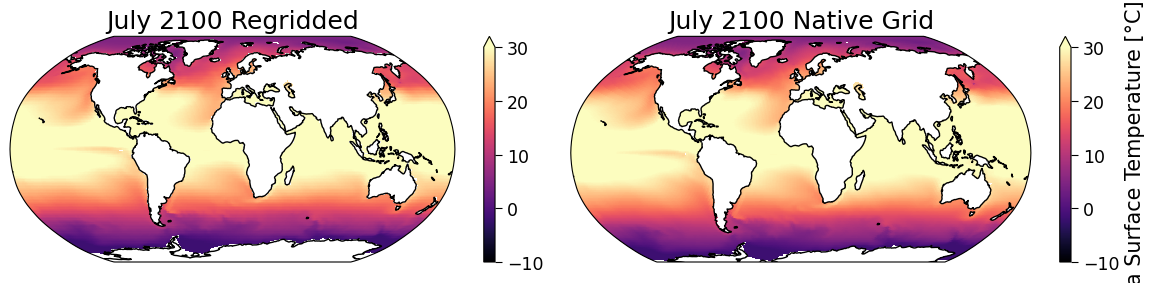

In [16]:

fig, ([ax_regridded, ax_native]) = plt.subplots(
    ncols=2,
    figsize=[12,3],
    subplot_kw={'projection':ccrs.Robinson()}
)

# Native grid data
sst_future = sst_ssp585.sel(time='2100-07').squeeze()
sst_future.plot(ax=ax_native, x='lon', y='lat', transform=ccrs.PlateCarree(), vmin=-10, vmax=30, cmap='magma', robust=True)
ax_native.coastlines()
ax_native.set_title('July 2100 Native Grid')

# Regridded data
sst_future_regridded = sst_ssp585_regridded.sel(time='2100-07').squeeze()
sst_future_regridded.plot(ax=ax_regridded, x='lon', y='lat', transform=ccrs.PlateCarree(), vmin=-10, vmax=30, cmap='magma', robust=True)
ax_regridded.coastlines()
ax_regridded.set_title('July 2100 Regridded')


## **Questions 1.3**

1. Is this what you expected to see after regridding the data?

In [ ]:
# to_remove explanation

"""
1. They look similar, which is what we expect from the regridding operation. It should not significantly change the underlying spatial information (i.e., the data), it should just adjust the locations at which that information is provided.
""";

# **Summary**

In Tutorial 1 you have: 

*   Loaded and manipulated data from a CMIP6 model under a high-emissions future scenario experiment
*   Created maps of future projected changes in the Earth system using CMIP6 data
*   Converted/regridded CMIP6 model data onto a desired grid. This is a critical processing step that allows us to directly compare data from different models and/or observations 


# **Resources**

Data for this tutorial can be accessed [here](https://gallery.pangeo.io/repos/pangeo-gallery/cmip6/index.html).